In [1]:
pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "krzysztofmusia" # użytkownik z pliku json od Kaggle
os.environ['KAGGLE_KEY'] = "7fda07d7b3e744a7866df075887f8a44" # klucz z pliku json od Kaggle

In [3]:
!kaggle datasets download -d chrisfilo/fruit-recognition # pobieranie datasetu z Kaggle

100% 7.90G/7.92G [01:20<00:00, 25.9MB/s]
100% 7.92G/7.92G [01:20<00:00, 106MB/s] 


In [4]:
!unzip -q fruit-recognition.zip # rozpakowywanie

In [5]:
import pandas as pd
import numpy as np

import os

import shutil

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import plotly.graph_objects as go

import cv2
import itertools
import pathlib
import warnings
import os
import random
import time
import gc
from IPython.display import Markdown, display
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout,SeparableConv2D, Activation, BatchNormalization, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

In [6]:
!rm -rf ./images

In [7]:
data_dir = './images' # katalog  ze wszystkimi obrazkami

In [8]:
base_dir = './Apple' # katalog główny z jabłkami i podział na kategorie
raw_no_of_files = {}
classes = ['Apple A', 'Apple B', 'Apple C', 'Apple D', 'Apple E', 'Apple F']
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('Apple A', 692), ('Apple B', 740), ('Apple C', 1002), ('Apple D', 1033), ('Apple E', 664), ('Apple F', 2030)])

In [9]:
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_applea_dir = os.path.join(train_dir, 'Apple A')
train_appleb_dir = os.path.join(train_dir, 'Apple B')
train_applec_dir = os.path.join(train_dir, 'Apple C')
train_appled_dir = os.path.join(train_dir, 'Apple D')
train_applee_dir = os.path.join(train_dir, 'Apple E')
train_applef_dir = os.path.join(train_dir, 'Apple F')

valid_applea_dir = os.path.join(valid_dir, 'Apple A')
valid_appleb_dir = os.path.join(valid_dir, 'Apple B')
valid_applec_dir = os.path.join(valid_dir, 'Apple C')
valid_appled_dir = os.path.join(valid_dir, 'Apple D')
valid_applee_dir = os.path.join(valid_dir, 'Apple E')
valid_applef_dir = os.path.join(valid_dir, 'Apple F')

test_applea_dir = os.path.join(test_dir, 'Apple A')
test_appleb_dir = os.path.join(test_dir, 'Apple B')
test_applec_dir = os.path.join(test_dir, 'Apple C')
test_appled_dir = os.path.join(test_dir, 'Apple D')
test_applee_dir = os.path.join(test_dir, 'Apple E')
test_applef_dir = os.path.join(test_dir, 'Apple F')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_applea_dir, train_appleb_dir, train_applec_dir, train_appled_dir, train_applee_dir, train_applef_dir,
        valid_applea_dir, valid_appleb_dir, valid_applec_dir, valid_appled_dir, valid_applee_dir, valid_applef_dir,
        test_applea_dir, test_appleb_dir,test_applec_dir, test_appled_dir, test_applee_dir, test_applef_dir ]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [10]:
applea_fnames = os.listdir(os.path.join(base_dir, 'Apple A'))
appleb_fnames = os.listdir(os.path.join(base_dir, 'Apple B'))
applec_fnames = os.listdir(os.path.join(base_dir, 'Apple C'))
appled_fnames = os.listdir(os.path.join(base_dir, 'Apple D'))
applee_fnames = os.listdir(os.path.join(base_dir, 'Apple E'))
applef_fnames = os.listdir(os.path.join(base_dir, 'Apple F'))

applea_fnames = [fname for fname in applea_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
appleb_fnames = [fname for fname in appleb_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
applec_fnames = [fname for fname in applec_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
appled_fnames = [fname for fname in appled_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
applee_fnames = [fname for fname in applee_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
applef_fnames = [fname for fname in applef_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [11]:
size = min(len(applea_fnames), len(appleb_fnames), len(applec_fnames), len(appled_fnames), len(applee_fnames), len(applef_fnames) )

train_size = int(np.floor(0.5 * size)) # zbiór treningowy ustawiony na 0,5
valid_size = int(np.floor(0.2 * size)) # zbiór treningowy ustawiony na 0,2
test_size = size - train_size - valid_size # zbiór testowy 0,3 jako różnica całego zbioru i zbiorów treningowego i walidacyjnego

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [12]:
# Policzenie elementów w wybranych zbiorach
for i, fname in enumerate(applea_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'Apple A', fname)
        dst = os.path.join(train_applea_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'Apple A', fname)
        dst = os.path.join(valid_applea_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'Apple A', fname)
        dst = os.path.join(test_applea_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(appleb_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'Apple B', fname)
        dst = os.path.join(train_appleb_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'Apple B', fname)
        dst = os.path.join(valid_appleb_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'Apple B', fname)
        dst = os.path.join(test_appleb_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(applec_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'Apple C', fname)
        dst = os.path.join(train_applec_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'Apple C', fname)
        dst = os.path.join(valid_applec_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'Apple C', fname)
        dst = os.path.join(test_applec_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(appled_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'Apple D', fname)
        dst = os.path.join(train_appled_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'Apple D', fname)
        dst = os.path.join(valid_appled_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'Apple D', fname)
        dst = os.path.join(test_appled_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(applee_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'Apple E', fname)
        dst = os.path.join(train_applee_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'Apple E', fname)
        dst = os.path.join(valid_applee_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'Apple E', fname)
        dst = os.path.join(test_applee_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(applef_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'Apple F', fname)
        dst = os.path.join(train_applef_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'Apple F', fname)
        dst = os.path.join(valid_applef_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'Apple F', fname)
        dst = os.path.join(test_applef_dir, fname)
        shutil.copyfile(src, dst)

print('Jałbko A - zbiór treningowy', len(os.listdir(train_applea_dir)))
print('Jałbko A  - zbiór walidacyjny', len(os.listdir(valid_applea_dir)))
print('Jałbko A  - zbiór testowy', len(os.listdir(test_applea_dir)))

print('Jałbko B - zbiór treningowy', len(os.listdir(train_appleb_dir)))
print('Jałbko B  - zbiór walidacyjny', len(os.listdir(valid_appleb_dir)))
print('Jałbko B  - zbiór testowy', len(os.listdir(test_appleb_dir)))

print('Jałbko C - zbiór treningowy', len(os.listdir(train_applec_dir)))
print('Jałbko C  - zbiór walidacyjny', len(os.listdir(valid_applec_dir)))
print('Jałbko C  - zbiór testowy', len(os.listdir(test_applec_dir)))

print('Jałbko D - zbiór treningowy', len(os.listdir(train_appled_dir)))
print('Jałbko D  - zbiór walidacyjny', len(os.listdir(valid_appled_dir)))
print('Jałbko D  - zbiór testowy', len(os.listdir(test_appled_dir)))

print('Jałbko E - zbiór treningowy', len(os.listdir(train_applee_dir)))
print('Jałbko E  - zbiór walidacyjny', len(os.listdir(valid_applee_dir)))
print('Jałbko E  - zbiór testowy', len(os.listdir(test_applee_dir)))

print('Jałbko F - zbiór treningowy', len(os.listdir(train_applef_dir)))
print('Jałbko F  - zbiór walidacyjny', len(os.listdir(valid_applef_dir)))
print('Jałbko F  - zbiór testowy', len(os.listdir(test_applef_dir)))

Jałbko A - zbiór treningowy 333
Jałbko A  - zbiór walidacyjny 132
Jałbko A  - zbiór testowy 199
Jałbko B - zbiór treningowy 333
Jałbko B  - zbiór walidacyjny 132
Jałbko B  - zbiór testowy 199
Jałbko C - zbiór treningowy 333
Jałbko C  - zbiór walidacyjny 132
Jałbko C  - zbiór testowy 199
Jałbko D - zbiór treningowy 333
Jałbko D  - zbiór walidacyjny 132
Jałbko D  - zbiór testowy 199
Jałbko E - zbiór treningowy 333
Jałbko E  - zbiór walidacyjny 132
Jałbko E  - zbiór testowy 199
Jałbko F - zbiór treningowy 333
Jałbko F  - zbiór walidacyjny 132
Jałbko F  - zbiór testowy 199


(-0.5, 319.5, 257.5, -0.5)

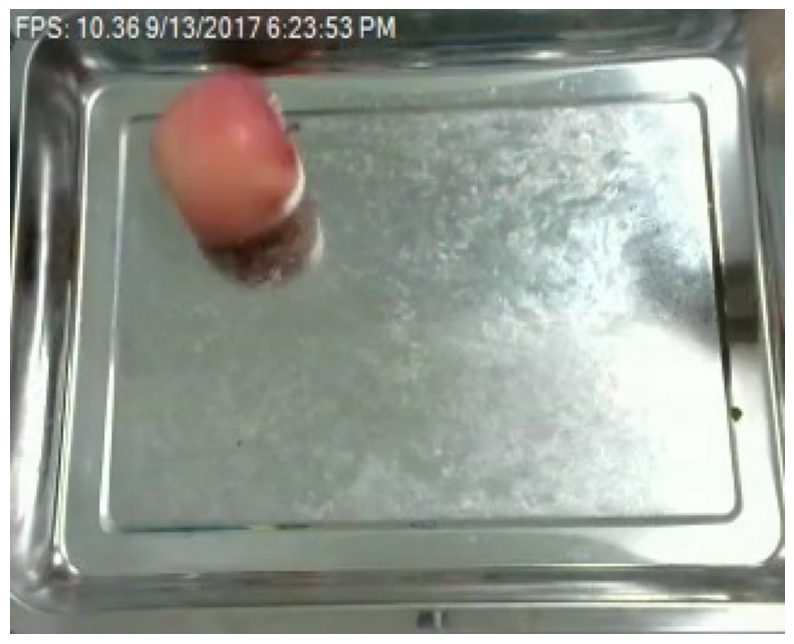

In [13]:
# Podgląd przykładowego obrazka z kategorii A
idx = 10
names_mapping = dict(enumerate(applea_fnames))
img_path = os.path.join(train_applea_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 479.5, 321.5, -0.5)

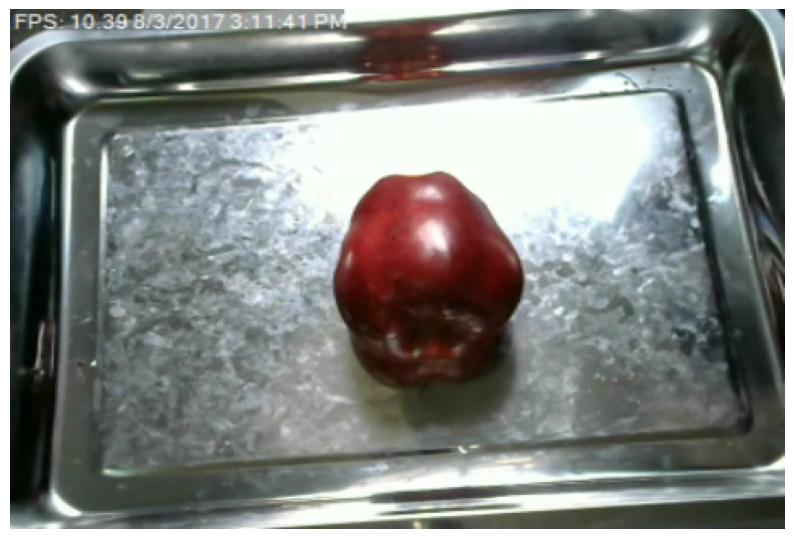

In [14]:
# Podgląd przykładowego obrazka z kategorii B
idx = 15
names_mapping = dict(enumerate(appleb_fnames))
img_path = os.path.join(train_appleb_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [15]:
# Augmentacja
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 1998 images belonging to 6 classes.
Found 792 images belonging to 6 classes.


In [16]:
# Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki augmentacji danych.
def display_augmented_images(directory, idx):
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

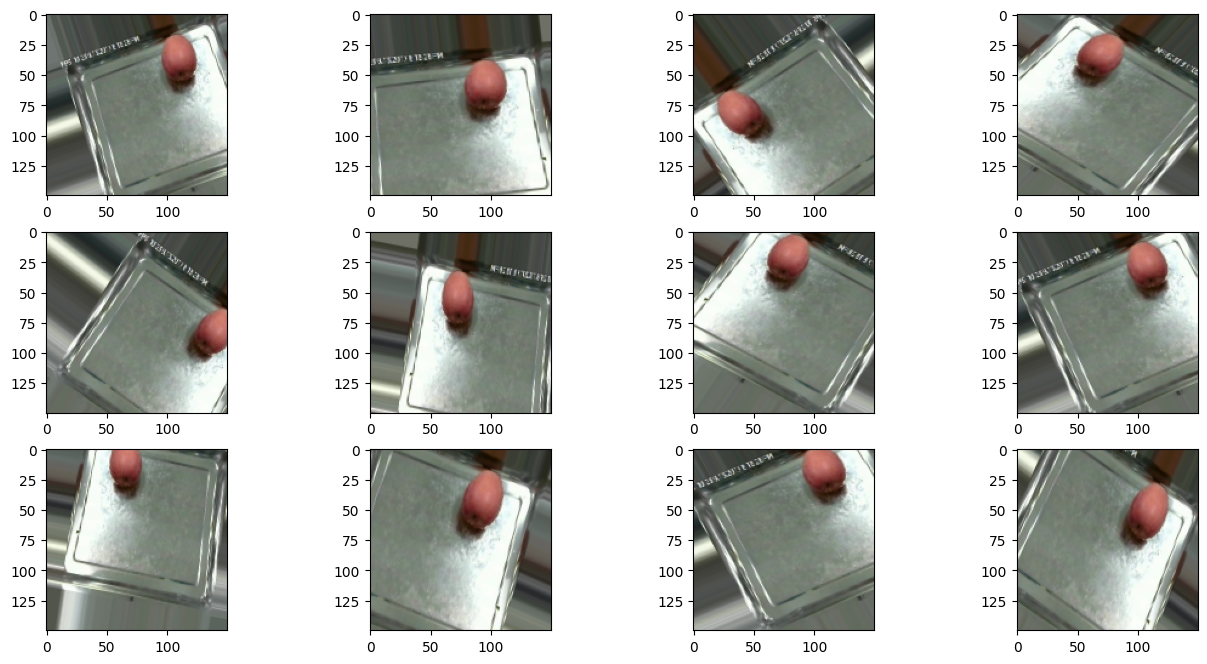

In [17]:
display_augmented_images(train_applea_dir, idx)

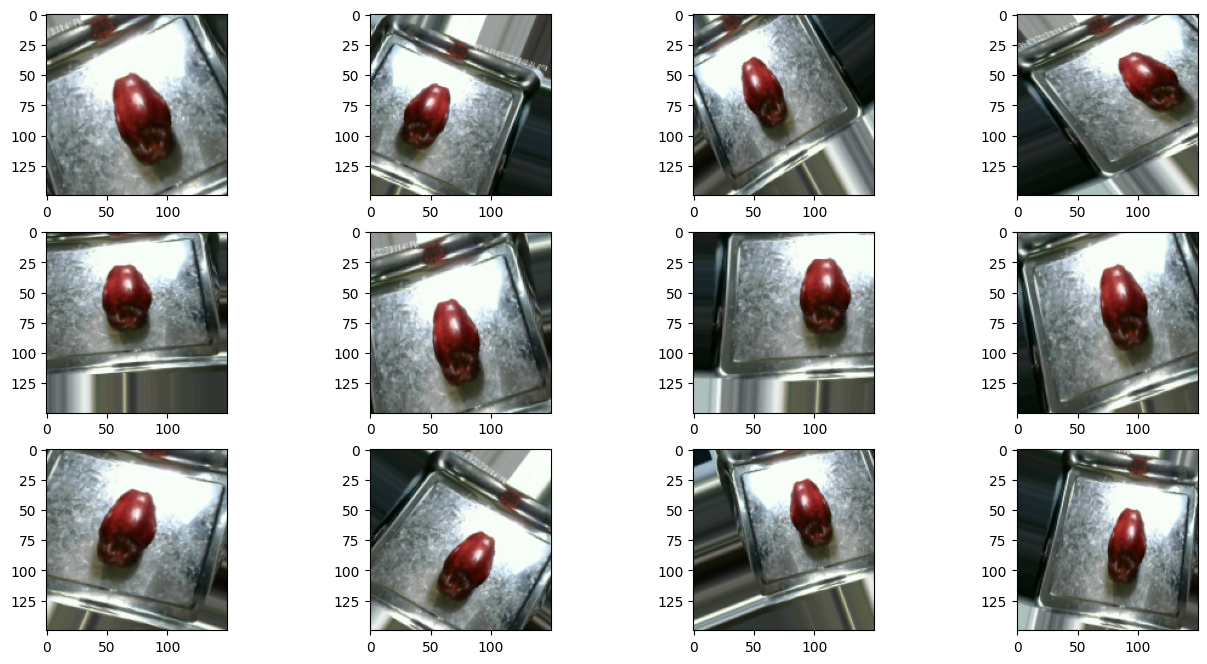

In [18]:
display_augmented_images(train_appleb_dir, idx)

In [19]:
# Model - budowa
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [20]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [21]:
!rm -rf logs
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [22]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

Epoch 1/30
10/10 [==============================] - 17s 472ms/step - loss: 1.7982 - accuracy: 0.1688 - val_loss: 1.7813 - val_accuracy: 0.2969
Epoch 2/30
10/10 [==============================] - 5s 524ms/step - loss: 1.7879 - accuracy: 0.2031 - val_loss: 1.7704 - val_accuracy: 0.2422
Epoch 3/30
10/10 [==============================] - 4s 414ms/step - loss: 1.7788 - accuracy: 0.2250 - val_loss: 1.7599 - val_accuracy: 0.3125
Epoch 4/30
10/10 [==============================] - 5s 485ms/step - loss: 1.7513 - accuracy: 0.2583 - val_loss: 1.7224 - val_accuracy: 0.3281
Epoch 5/30
10/10 [==============================] - 4s 426ms/step - loss: 1.6899 - accuracy: 0.3219 - val_loss: 1.7954 - val_accuracy: 0.1172
Epoch 6/30
10/10 [==============================] - 4s 417ms/step - loss: 1.6530 - accuracy: 0.3344 - val_loss: 1.5961 - val_accuracy: 0.3281
Epoch 7/30
10/10 [==============================] - 5s 523ms/step - loss: 1.5833 - accuracy: 0.3187 - val_loss: 1.5247 - val_accuracy: 0.3984
Epoch

In [23]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [24]:
# Model VGG16
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [25]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=6, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 16,813,638
Trainable params: 16,813,638
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [27]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=50,
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

Epoch 1/50
10/10 [==============================] - 15s 498ms/step - loss: 1.9066 - accuracy: 0.1625 - val_loss: 1.8203 - val_accuracy: 0.1484
Epoch 2/50
10/10 [==============================] - 8s 808ms/step - loss: 1.7961 - accuracy: 0.1656 - val_loss: 1.7810 - val_accuracy: 0.1406
Epoch 3/50
10/10 [==============================] - 7s 687ms/step - loss: 1.7881 - accuracy: 0.2344 - val_loss: 1.7850 - val_accuracy: 0.1250
Epoch 4/50
10/10 [==============================] - 5s 489ms/step - loss: 1.7841 - accuracy: 0.2094 - val_loss: 1.7592 - val_accuracy: 0.2891
Epoch 5/50
10/10 [==============================] - 6s 579ms/step - loss: 1.7753 - accuracy: 0.2406 - val_loss: 1.8214 - val_accuracy: 0.1875
Epoch 6/50
10/10 [==============================] - 5s 457ms/step - loss: 1.7784 - accuracy: 0.2450 - val_loss: 1.7059 - val_accuracy: 0.3125
Epoch 7/50
10/10 [==============================] - 5s 514ms/step - loss: 1.7100 - accuracy: 0.2483 - val_loss: 1.6420 - val_accuracy: 0.2734
Epoch

In [28]:
import plotly.graph_objects as go
plot_hist(history)

In [29]:
# Sprawdzenie modelu na zbiorze testowym
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob

Found 1194 images belonging to 6 classes.


array([[9.9995685e-01, 2.0283216e-05, 2.1841803e-05, 5.3770884e-07,
        3.1581553e-07, 2.2050885e-07],
       [9.9270141e-01, 4.5502177e-03, 2.4924648e-03, 1.2791777e-04,
        8.0238598e-05, 4.7639958e-05],
       [9.9989581e-01, 5.4765056e-05, 2.2154682e-05, 1.3314014e-05,
        4.3277482e-06, 9.5952964e-06],
       ...,
       [4.5177661e-13, 8.7600015e-16, 7.3657721e-14, 1.7595086e-08,
        3.1885036e-11, 1.0000000e+00],
       [5.5367871e-15, 2.4419351e-17, 5.2084776e-15, 5.0871019e-09,
        3.3844715e-12, 1.0000000e+00],
       [5.2612338e-11, 2.2873741e-13, 2.3084847e-11, 6.3591892e-07,
        1.9575699e-09, 9.9999940e-01]], dtype=float32)

In [30]:
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 0, 0, ..., 5, 5, 5])

In [31]:
predictions  = pd.DataFrame({'class': y_pred})
predictions

class
0         0
1         0
2         0
3         0
4         0
...     ...
1189      5
1190      5
1191      5
1192      5
1193      5

[1194 rows x 1 columns]

In [32]:
y_true = test_generator.classes
y_true

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [33]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, ..., 5, 5, 5])

In [34]:
test_generator.class_indices

{'Apple A': 0,
 'Apple B': 1,
 'Apple C': 2,
 'Apple D': 3,
 'Apple E': 4,
 'Apple F': 5}

In [35]:
classes = list(test_generator.class_indices.keys())
classes

['Apple A', 'Apple B', 'Apple C', 'Apple D', 'Apple E', 'Apple F']

In [36]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[199,   0,   0,   0,   0,   0],
       [  1, 198,   0,   0,   0,   0],
       [  0,   0, 199,   0,   0,   0],
       [  0,   0,   0, 199,   0,   0],
       [  0,   0,   0,   0, 199,   0],
       [  0,   0,   0,   0,   0, 199]])

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       199
           1       1.00      0.99      1.00       199
           2       1.00      1.00      1.00       199
           3       1.00      1.00      1.00       199
           4       1.00      1.00      1.00       199
           5       1.00      1.00      1.00       199

    accuracy                           1.00      1194
   macro avg       1.00      1.00      1.00      1194
weighted avg       1.00      1.00      1.00      1194



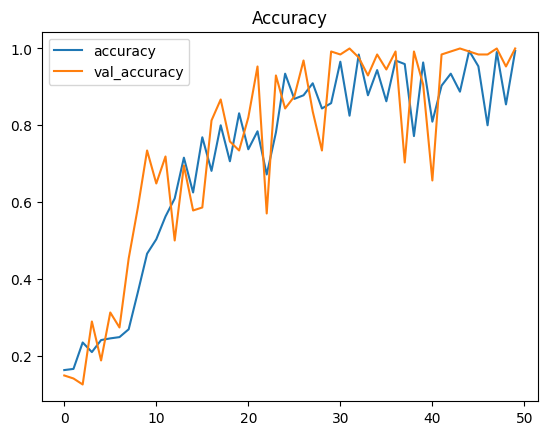

In [38]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [39]:
model.save('model_jablka_wszystkie_klasy_ok_2.h5')

In [40]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors

y_true  y_pred
Apple A/Apple 1.png          0       0
Apple A/Apple 101.png        0       0
Apple A/Apple 102.png        0       0
Apple A/Apple 103.png        0       0
Apple A/Apple 105.png        0       0
...                        ...     ...
Apple F/scene05441.png       5       5
Apple F/scene05781.png       5       5
Apple F/scene06941.png       5       5
Apple F/scene07021.png       5       5
Apple F/scene07281.png       5       5

[1194 rows x 2 columns]

In [41]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

y_true  y_pred  is_incorrect
Apple A/Apple 1.png          0       0             0
Apple A/Apple 101.png        0       0             0
Apple A/Apple 102.png        0       0             0
Apple A/Apple 103.png        0       0             0
Apple A/Apple 105.png        0       0             0
...                        ...     ...           ...
Apple F/scene05441.png       5       5             0
Apple F/scene05781.png       5       5             0
Apple F/scene06941.png       5       5             0
Apple F/scene07021.png       5       5             0
Apple F/scene07281.png       5       5             0

[1194 rows x 3 columns]

In [42]:
errors[errors['is_incorrect'] == 1].index

Index(['Apple B/Red Applee10.png'], dtype='object')

(-0.5, 319.5, 257.5, -0.5)

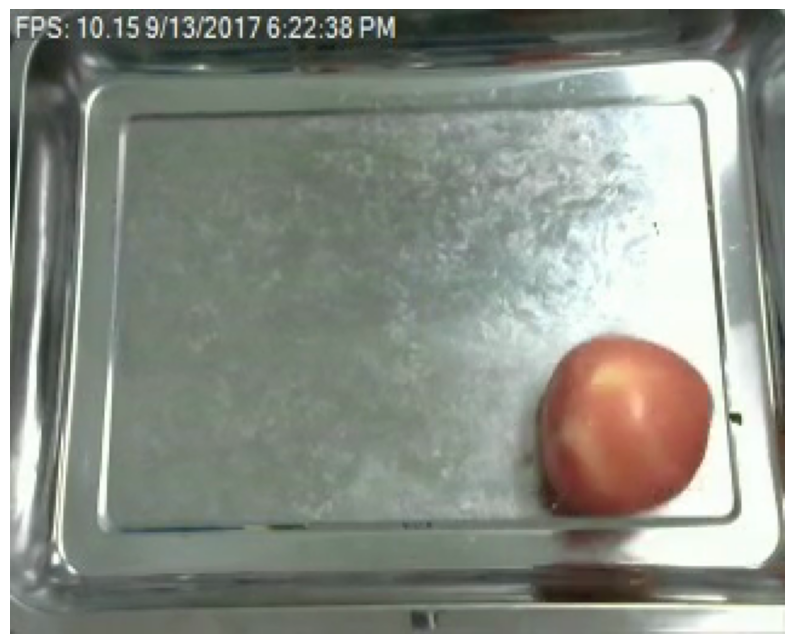

In [43]:
img_path = os.path.join(test_applea_dir, 'Apple 531.png')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 319.5, 257.5, -0.5)

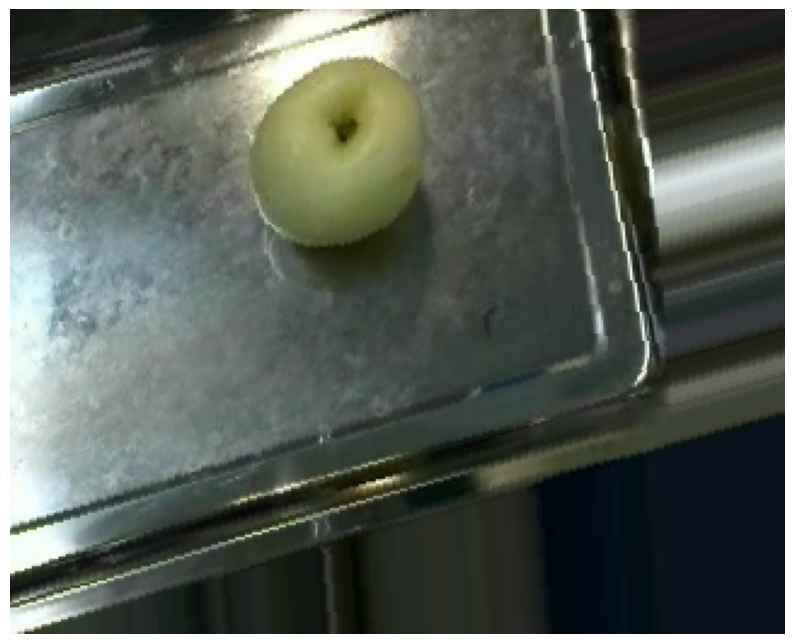

In [44]:
img_path = os.path.join(test_applef_dir, 'Apple F _0_2447.png')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [45]:
errors[errors['is_incorrect'] == 1]

y_true  y_pred  is_incorrect
Apple B/Red Applee10.png       1       0             1